# Credit Scoring Model

**Credit scoring model to predict the creditworthiness of individuals based on historical financial data. Utilize classification algorithms and assess the model's accuracy.**

## 1- Importing Libraries

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import re

## 2- Preprocess the Data

In [2]:
# Load Data from CSV file
dataset = pd.read_csv('Data.csv')

In [3]:
# Dataset shape
dataset.shape

(3000, 30)

In [4]:
# Discover any missing values
dataset.isnull().sum()

TARGET               0
ID                   0
DerogCnt             0
CollectCnt           0
BanruptcyInd         0
InqCnt06             0
InqTimeLast        188
InqFinanceCnt24      0
TLTimeFirst          0
TLTimeLast           0
TLCnt03              0
TLCnt12              0
TLCnt24              0
TLCnt                3
TLSum               40
TLMaxSum            40
TLSatCnt             4
TLDel60Cnt           0
TLBadCnt24           0
TL75UtilCnt         99
TL50UtilCnt         99
TLBalHCPct          41
TLSatPct             4
TLDel3060Cnt24       0
TLDel90Cnt24         0
TLDel60CntAll        0
TLOpenPct            3
TLBadDerogCnt        0
TLDel60Cnt24         0
TLOpen24Pct          3
dtype: int64

In [5]:
# Convert the strings to numeriacal data
def clean_and_convert(value):
    if isinstance(value, str):
        value = value.replace('$', '').replace(',', '').replace('%', '').strip()
        return float(value)
    return value

# Apply the cleaning function to specific columns
columns_to_clean = ["TLSum", "TLMaxSum", "TLBalHCPct", "TLSatPct", "TLOpenPct", "TLOpen24Pct"]
for col in columns_to_clean:
    dataset[col] = dataset[col].apply(clean_and_convert)

In [6]:
# Replance the missing values with the mean of the column
dataset = dataset.fillna(dataset.mean())

# Recheck for missing values
dataset.isnull().sum()

TARGET             0
ID                 0
DerogCnt           0
CollectCnt         0
BanruptcyInd       0
InqCnt06           0
InqTimeLast        0
InqFinanceCnt24    0
TLTimeFirst        0
TLTimeLast         0
TLCnt03            0
TLCnt12            0
TLCnt24            0
TLCnt              0
TLSum              0
TLMaxSum           0
TLSatCnt           0
TLDel60Cnt         0
TLBadCnt24         0
TL75UtilCnt        0
TL50UtilCnt        0
TLBalHCPct         0
TLSatPct           0
TLDel3060Cnt24     0
TLDel90Cnt24       0
TLDel60CntAll      0
TLOpenPct          0
TLBadDerogCnt      0
TLDel60Cnt24       0
TLOpen24Pct        0
dtype: int64

In [7]:
print(dataset.shape)

(3000, 30)


In [8]:
for col in dataset.columns:
    print(f'The correlation between {col} and the target is {dataset[col].corr(dataset["TARGET"])}')

The correlation between TARGET and the target is 1.0
The correlation between ID and the target is -0.003318256169907056
The correlation between DerogCnt and the target is 0.08809950482569659
The correlation between CollectCnt and the target is 0.09374759560019383
The correlation between BanruptcyInd and the target is 0.02565139056126972
The correlation between InqCnt06 and the target is 0.10666335429785379
The correlation between InqTimeLast and the target is -0.03313721896027608
The correlation between InqFinanceCnt24 and the target is 0.13256206912118887
The correlation between TLTimeFirst and the target is -0.06959733719304602
The correlation between TLTimeLast and the target is 0.03064791423716407
The correlation between TLCnt03 and the target is -0.03611602249447941
The correlation between TLCnt12 and the target is -0.012390690239577746
The correlation between TLCnt24 and the target is -0.009525041339920354
The correlation between TLCnt and the target is -0.04356486797286941
The c

In [9]:
# We can see that ID has no correlation with the target, so we can drop it
dataset = dataset.drop(columns=['ID'])

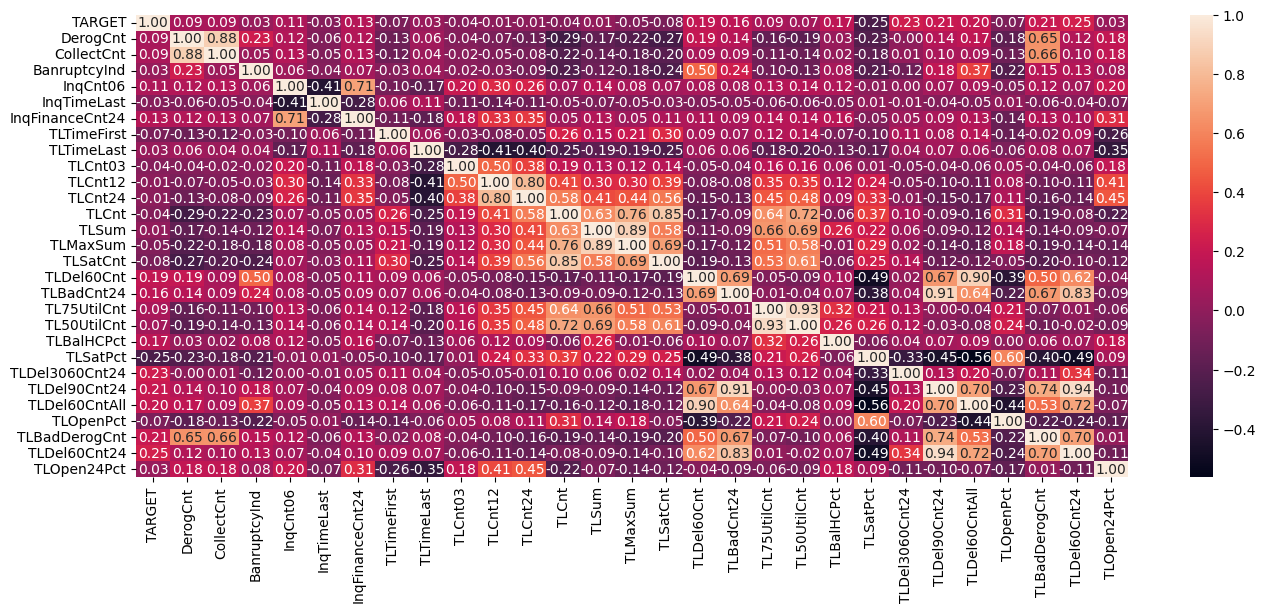

In [10]:
# We draw the correlation matrix for more insights
plt.figure(figsize=(16, 6)) 
sns.heatmap(dataset.corr(), annot=True, fmt=".2f")
plt.show()

In [11]:
# CollectCnt (since it is highly correlated with DerogCnt)
# BankruptcyInd (since it is highly correlated with DerogCnt and TLBadDerogCnt)
# TLCnt03 or TLCnt12 (since they are highly correlated with each other)
# TLSum (since it is highly correlated with TLCnt)
# TLMaxSum (since it is highly correlated with TLSatCnt)
# TLDel60Cnt24 (since it is highly correlated with TLDel60CntAll)
# TLOpenPct (since it is highly correlated with TLOpen24Pct)

dataset = dataset.drop(columns=['CollectCnt', 'BanruptcyInd', 'TLCnt03', 'TLSum', 'TLMaxSum', 'TLDel60Cnt24', 'TLOpenPct'])

In [12]:
# Next we remove any columns that have a correlation of between -0.03 and 0.03 with the TARGET
for col in dataset.columns:
    if dataset[col].corr(dataset["TARGET"]) > -0.03 and dataset[col].corr(dataset["TARGET"]) < 0.03:
        dataset = dataset.drop(columns=[col])

## 3- Model Training

In [13]:
# Now we normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(dataset)
data_scaled = pd.DataFrame(data_scaled, columns=dataset.columns)

def clean_feature_names(df):
    df.columns = [re.sub(r'[^a-zA-Z0-9_]', '_', col) for col in df.columns]
    return df


df = clean_feature_names(data_scaled)
data_scaled.head()

,TARGET,DerogCnt,InqCnt06,InqTimeLast,InqFinanceCnt24,TLTimeFirst,TLTimeLast,TLCnt,TLSatCnt,TLDel60Cnt,TLBadCnt24,TL75UtilCnt,TL50UtilCnt,TLBalHCPct,TLSatPct,TLDel3060Cnt24,TLDel90Cnt24,TLDel60CntAll,TLBadDerogCnt,TLOpen24Pct
0,1.0,0.058824,0.100,0.000000,0.104167,0.119741,0.078947,0.125,0.280702,0.052632,0.0625,0.15,0.130435,0.273810,0.21,0.250,0.157895,0.155556,0.085106,0.000000
1,1.0,0.294118,0.075,0.041667,0.062500,0.008630,0.040936,0.025,0.017544,0.000000,0.0000,0.05,0.043478,0.238095,0.00,0.000,0.000000,0.000000,0.255319,0.166667
2,1.0,0.000000,0.025,0.208333,0.020833,0.375405,0.020468,0.475,0.368421,0.026316,0.0625,0.20,0.217391,0.107143,0.65,0.000,0.052632,0.022222,0.021277,0.088333
3,1.0,0.156863,0.150,0.041667,0.208333,0.010787,0.011696,0.075,0.017544,0.026316,0.0000,0.10,0.130435,0.270833,0.25,0.125,0.052632,0.022222,0.148936,0.221667
4,1.0,0.058824,0.225,0.000000,0.166667,0.133765,0.152047,0.025,0.052632,0.105263,0.0625,0.05,0.043478,0.372024,0.00,0.000,0.052632,0.088889,0.063830,0.000000


In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_scaled.drop('TARGET', axis=1), data_scaled['TARGET'], test_size=0.2, random_state=0)

In [15]:
# Create and fit the models
model1 = RandomForestClassifier(n_estimators=1000, random_state=42)
model1.fit(X_train, y_train)

model2 = LogisticRegression(random_state=42)
model2.fit(X_train, y_train)

model3 = SVC(random_state=42)
model3.fit(X_train, y_train)

model4 = KNeighborsClassifier()
model4.fit(X_train, y_train)

model5 = GradientBoostingClassifier(n_estimators=100, random_state=42)
model5.fit(X_train, y_train)

model6 = xgb.XGBClassifier(n_estimators=100, random_state=42)
model6.fit(X_train, y_train)

model7 = lgb.LGBMClassifier(n_estimators=100, random_state=42)
model7.fit(X_train, y_train)

model8 = GaussianNB()
model8.fit(X_train, y_train)

model9 = MLPClassifier(random_state=42)
model9.fit(X_train, y_train)

model10 = AdaBoostClassifier(n_estimators=100, random_state=42)
model10.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 398, number of negative: 2002
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.165833 -> initscore=-1.615450
[LightGBM] [Info] Start training from score -1.615450


/home/alpha/.local/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alpha/.local/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(n_estimators=100, random_state=42)

## 4- Model Evaluation

In [16]:
models = [model1, model2, model3, model4, model5, model6, model7, model8, model9, model10]
accuracy = [accuracy_score(y_test, model.predict(X_test)) for model in models]


# Create a dictionary of model names and their accuracies
accuracies = {
    'RandomForest': accuracy[0],
    'LogisticRegression': accuracy[1],
    'SVM': accuracy[2],
    'KNN': accuracy[3],
    'GradientBoosting': accuracy[4],
    'XGBoost': accuracy[5],
    'LightGBM': accuracy[6],
    'NaiveBayes': accuracy[7],
    'NeuralNetwork': accuracy[8],
    'AdaBoost': accuracy[9]
}

In [17]:
results_df = pd.DataFrame(list(accuracies.items()), columns=['Model', 'Accuracy'])          # Convert to a dataframe

In [18]:
results_df = pd.DataFrame(list(accuracies.items()), columns=['Model', 'Accuracy'])
results_table = results_df.sort_values(by='Accuracy', ascending=False)
print(results_table)

                Model  Accuracy
2                 SVM  0.836667
9            AdaBoost  0.835000
0        RandomForest  0.833333
1  LogisticRegression  0.833333
8       NeuralNetwork  0.831667
3                 KNN  0.830000
6            LightGBM  0.828333
4    GradientBoosting  0.825000
5             XGBoost  0.816667
7          NaiveBayes  0.765000


/tmp/ipykernel_51614/3946663133.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')


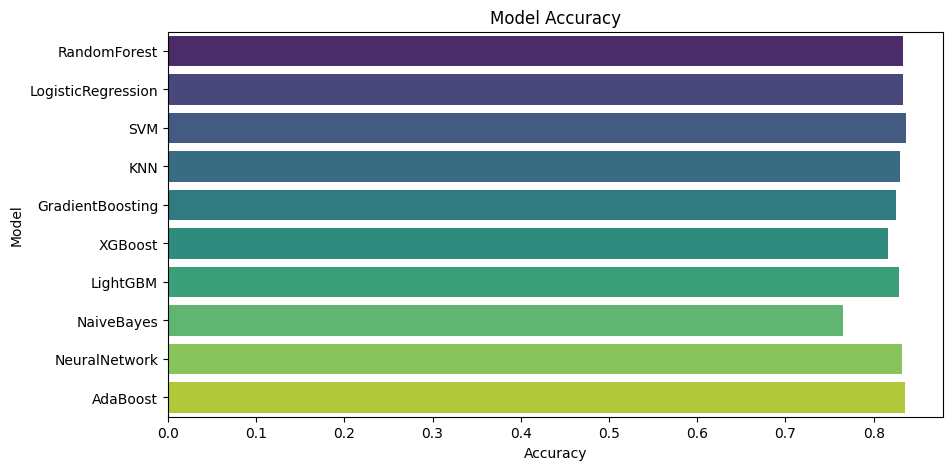

In [19]:
# plot the results
plt.figure(figsize=(10, 5))
sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')
plt.title('Model Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.show()